# Options Valuation

This notebook is an exploratory analysis of American-style options valuation for trading strategies. The goal is to investigate  valuation of Swedish large-cap stock options and create templates that can be productionalized. These templates will be in the areas of 1) Covered call, 2) Vertical spread (Bull call, Bear put),  3) Iron Condor, 4) Straddle, 5) Strangle, 6) Butterfly Spread, 7) Naked call, and more. 

TODO:
>Simulated price paths visualisation. Calculate Prob(any point in path is greater that strike). Create "fan" of price paths, use ARIMA-methods?

>Add better settings and data inputs. Should trickle down whole notebook. Also input for whole options series.

>Add distribution simulation as setting, e.g. normal from mean and stdev

>[DONE] Create modular plot functions for re-use

>[DONE] Modular option strategy builder. Simple functions that can be added to create PnL charts

>[DONE] Add histogram and treshold levels to charts

>Visualize all above strategies

>Simplify analysis parameters and inputs

>Refine charts

>Build dashboard?

>Connect to Avanza somehow? Other API?

### Price Simulation

In [1]:
#PnL diagram and distribution visualisation with thresholds
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
#Proxy data from BTC
btc_data_filepath = "data/BTC_CoinDesk.csv"
#Read BTC data from file
delim1 = ","
btcdata = pd.read_csv(btc_data_filepath, sep=delim1)
btcdata["Date"] = pd.DataFrame([x[0:10] for x in btcdata["date_UTC"]])
btcdata=btcdata.dropna()
btcdata["price_return"] = btcdata["price_USD"].pct_change()
btcdata = btcdata[["Date","price_USD","price_return"]]
btcdata=btcdata.dropna()
#btcdata["price_return"] = np.log(btcdata["price_return"])
btcdata.head()

,Date,price_USD,price_return
1,2013-10-02,125.58083,0.018830
2,2013-10-03,100.81083,-0.197243
3,2013-10-04,116.96700,0.160262
4,2013-10-05,121.17883,0.036009
5,2013-10-06,121.18516,0.000052


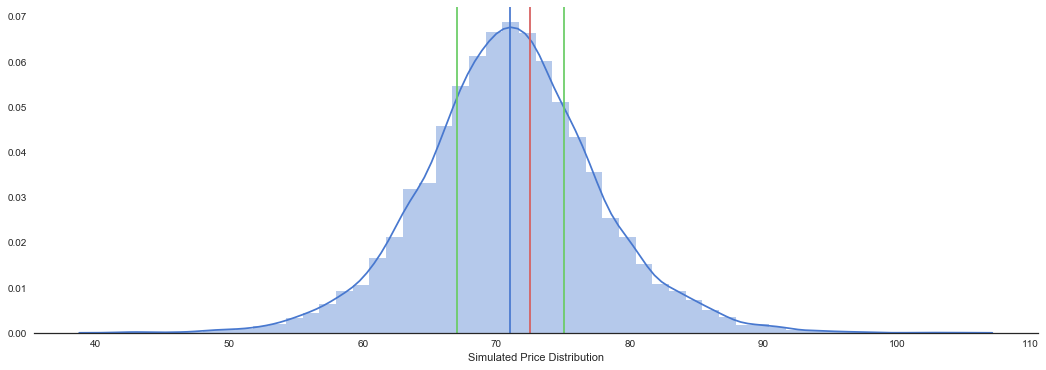

In [3]:
#Simulate data from empirical distribution
last_price = 70
days_forward = 5
sample_days_back = 1000
n_prices = 10000
strike = 72.5

def simulateForwardValue(price_start, days_forward, df_sample):
    pct_sum = np.sum(df_sample.sample(n=days_forward,replace=True))
    fwd_incr = 1+pct_sum #simple assumption, linear and independent path
    return price_start*fwd_incr

def simulateForwardDistribution(sim_len, price_start, days_forward, df_sample):
    sim_data = []
    for i in range(0,sim_len):
        sim_data.append(simulateForwardValue(price_start,days_forward,df_sample))
    return pd.DataFrame({'simulation_results':sim_data})

def getEmpProbGreater(threshold,df_sample):
    tot_count = df_sample.count()
    thres_count = df_sample[df_sample > threshold].dropna().count().values
    result = 0
    if tot_count.values > 0.0:
        result = thres_count/tot_count
    return result

simdata = simulateForwardDistribution(n_prices,last_price,days_forward,btcdata["price_return"].iloc[len(btcdata)-sample_days_back:len(btcdata)])
res = simdata.describe()
t_25 = res[4:5].values[0][0]
s_mean = simdata["simulation_results"].mean()
t_75 = res[6:7].values[0][0]

sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(1, 1, figsize=(18, 6), sharex=False)
sns.despine(left=True)
ax = sns.distplot(simdata, kde=True, color="b")
ax.set(xlabel=f'Simulated Price Distribution') #{var}

plt.axvline(t_25, 0, 1, color='g') 
plt.axvline(s_mean, 0, 1, color='b') 
plt.axvline(t_75, 0,1, color='g') 
plt.axvline(strike, 0,1, color='r') 

#TODO: add simulated paths here?

In [4]:
b = getEmpProbGreater(strike,simdata) #sample probability that price > strike in simulated distribution

In [5]:
a = getEmpProbGreater(last_price,simdata)
a-b

simulation_results    0.1717
dtype: float64

In [6]:
np.exp(1)

2.7182818284590451

In [7]:
len(btcdata)

1933

### Strategies

Define the basic strategies and create functions for later usage.

In [8]:
#Basic PnL functions take a scalar strike, vector of prices, and scalar premium as input

#Call profit/loss
def call_profit_loss(strike,price,premium):
    sp = price-strike
    ret = [(np.max([x,0])-premium) for x in sp]
    return ret

#Put profit/loss
def put_profit_loss(strike,price,premium):
    sp = strike-price
    ret = [(np.max([x,0])-premium) for x in sp]
    return ret

#Short call
def short_call_pnl(strike,price,premium):
    short_call = call_profit_loss(strike,price,premium)
    short_call = [(-1*x) for x in short_call]
    return short_call

#Short put
def short_put_pnl(strike,price,premium):
    short_put = put_profit_loss(strike,price,premium)
    short_put = [(-1*x) for x in short_put]  
    return short_put



Advanced strategies:

In [9]:
#Advanced PnL functions take a set of strikes and premiums along with the price vector

#Bull call - 

#Bull put - 

#Bear call - 

#Bear put - 



#Long call + put profit/loss
def callput_pnl(s1,s2,price,p1,p2):
    sp = np.add(call_profit_loss(s1,price,p1),put_profit_loss(s2,price,p2))
    return sp

#Long put + short put profit/loss
def long_short_put_pnl(s1,s2,price,p1,p2):
    sp = np.add(put_profit_loss(s1,price,p1),short_put_pnl(s2,price,p2))
    return sp
    

Modular plot functions

In [31]:
#Set of modular plot functions
#Usage: create a plot area and then use functions with specified inputs, to add plots as modules

#Imports
from scipy.stats import beta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Basic PnL chart with label,title, xlabel, ylabel and vertical strike line as well as horizontal line at zero
def plotStrikeBasic(ax,price,pnl_function, lbl, title, xlab,ylab,vstrike):
    ax.plot(price,pnl_function, 'k', label=lbl)
    ax.set_title(title)
    ax.set(xlabel=xlab, ylabel=ylab)
    ax.axvline(vstrike, 0, 1, color='b',label='Strike') 
    ax.axhline(0, 0,1, color='g') 
    ax.legend()

#Advances PnL chart with extra strike
def plotStrikeExtra(ax,price,pnl_function, lbl, title, xlab,ylab,vstrike1,vstrike2):
    ax.plot(price,pnl_function, 'k', label=lbl)
    ax.set_title(title)
    ax.set(xlabel=xlab, ylabel=ylab)
    ax.axvline(vstrike1, 0, 1, color='b',label='s1') 
    ax.axvline(vstrike2, 0, 1, color='r',label='s2') 
    ax.axhline(0, 0,1, color='g') 
    ax.legend()
    
#Plot density function    
def plotDensityBasic(ax,data,title,xlab,ylab,vstrike1,vstrike2=False):
    sns.distplot(data, kde=True, color="b", ax=ax)
    ax.set_title(title)
    ax.set(xlabel=xlab, ylabel=ylab)
    ax.axvline(vstrike1, 0, 1, color='b',label='s1') 
    if vstrike2 is not False:
        ax.axvline(vstrike2, 0, 1, color='r',label='s2')
    ax.legend()

#Plot density or CDF function with two vertical lines    
def plotDensityExtra(ax,data,title,xlab,ylab,cuml,t1,tlab1,t2,tlab2):
    sns.distplot(data, kde=True, color="b", ax=ax,kde_kws=dict(cumulative=cuml),hist=False)
    ax.set_title(title)
    ax.set(xlabel=xlab, ylabel=ylab)
    ax.axvline(t1, 0, 1, color='r',label=tlab1)  
    ax.axvline(t2, 0, 1, color='g',label=tlab2)  
    ax.legend()

In [11]:
#Settings
s1 = 70
s2 = 70
pr1 = 1
pr2 = 0.7
    
t1 = 68
t2 = np.arange((s1+s2)/2-10, (s1+s2)/2+10, 1.0)

Plot simple long call/put

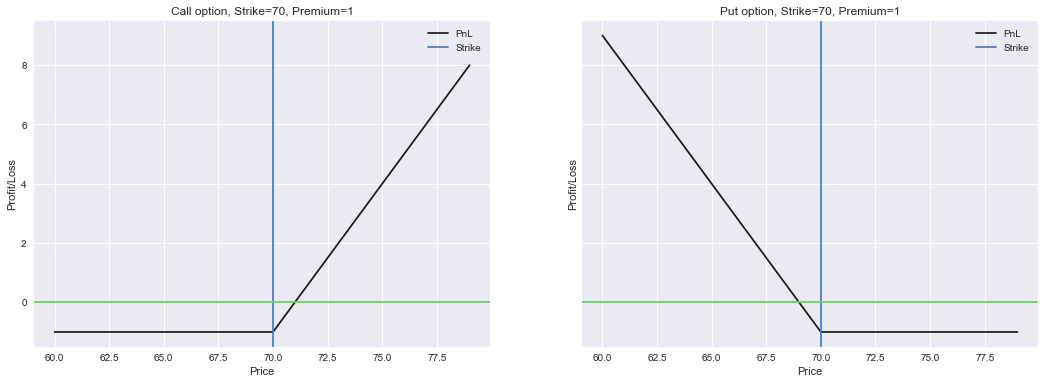

In [12]:
#Plot plain stragies

#Set plot area
sns.set(style="darkgrid")
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

#Plot Call 
call_pnl = call_profit_loss(s1,t2,pr1)
plotStrikeBasic(ax=ax1
                ,price=t2
                ,pnl_function=call_pnl
                ,lbl='PnL'
                ,title=f'Call option, Strike={s1}, Premium={pr1}'
                ,xlab='Price'
                ,ylab='Profit/Loss'
                ,vstrike=s1)

#Plot Put
put_pnl = put_profit_loss(s1,t2,pr1)
plotStrikeBasic(ax=ax2
                ,price=t2
                ,pnl_function=put_pnl
                ,lbl='PnL'
                ,title=f'Put option, Strike={s1}, Premium={pr1}'
                ,xlab='Price'
                ,ylab='Profit/Loss'
                ,vstrike=s1)


## Covered call

A covered call is a popular options strategy used to generate income in the form of options premiums. To execute a covered call, an investor holding a long position in an asset then writes (sells) call options on that same asset. Below shows the PnL diagram and analysis of this strategy.

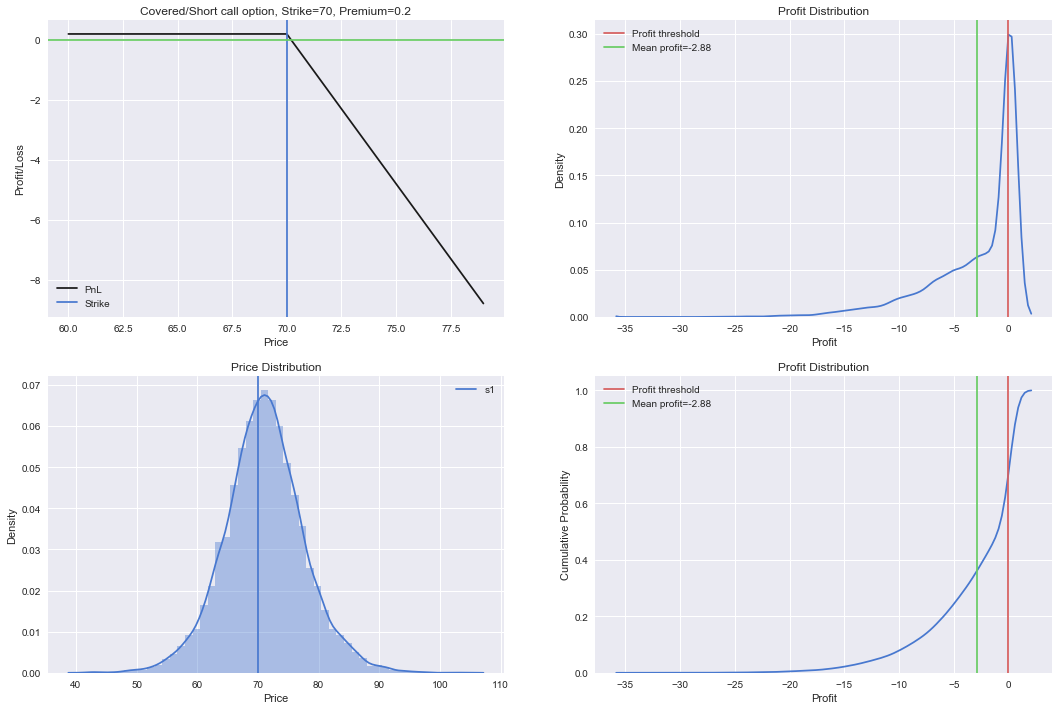

In [28]:
#Settings
s1 = 70
s2 = 70
pr1 = 0.2
pr2 = 0.7

curr_price = 68.96
curr_vol = curr_price*(29.65/100)/np.sqrt(52)
N=10000
    
t1 = 68
t2 = np.arange((s1+s2)/2-10, (s1+s2)/2+10, 1.0)

norm_sim = np.random.normal(curr_price,curr_vol,N)
simulated_values = simdata.values
sim_sc_pnl = short_call_pnl(strike=s1,price=simulated_values,premium=pr1)
avg_profit = np.round(np.mean(sim_sc_pnl),2)


#Set plot area
sns.set(style="darkgrid")
f, axes = plt.subplots(2, 2, figsize=(18, 12), sharey=False, sharex=False)

#Plot Call 
sc_pnl = short_call_pnl(strike=s1
                        ,price=t2
                        ,premium=pr1)
plotStrikeBasic(ax=axes[0,0]
                ,price=t2
                ,pnl_function=sc_pnl
                ,lbl='PnL'
                ,title=f'Covered/Short call option, Strike={s1}, Premium={pr1}'
                ,xlab='Price'
                ,ylab='Profit/Loss'
                ,vstrike=s1)

#Plot Density 
plotDensityBasic(ax=axes[1,0]
           ,data=simulated_values
           ,title=f'Price Distribution'
           ,xlab='Price'
           ,ylab='Density'
           ,vstrike1=s1)

#Distribution and profit analysis
plotDensityExtra(ax=axes[0,1]
           ,data=sim_sc_pnl
           ,title=f'Profit Distribution'
           ,xlab='Profit'
           ,ylab='Density'
           ,cuml=False
           ,t1=0
           ,tlab1='Profit threshold'
           ,t2=avg_profit
           ,tlab2=f'Mean profit={avg_profit}')  
    

#Plot profit CDF 
plotDensityExtra(ax=axes[1,1]
           ,data=sim_sc_pnl
           ,title=f'Profit Distribution'
           ,xlab='Profit'
           ,ylab='Cumulative Probability'
           ,cuml=True
           ,t1=0
           ,tlab1='Profit threshold'
           ,t2=avg_profit
           ,tlab2=f'Mean profit={avg_profit}')  

In [14]:
s1

70

## Vertical Spreads

An options strategy involving buying and selling of multiple options of the same underlying security, same expiration date, but at different strike prices. They can be created with either all calls or all puts. Here, one case in each category of all calls and one of all puts are considered.

In [19]:
#Bull/bear call - buy call with s1 and sell s2 where s1 < s2 (bull) / s1 > s2 (bear)
def long_short_call_pnl(s1,s2,p1,p2,price):
    sp = np.add(call_profit_loss(s1,price,p1),short_call_pnl(s2,price,p2))
    return sp

#Bull/bear put - buy put with s1 and sell s2 where s1 < s2 (bull) / s1 > s2 (bear)
def long_short_put_pnl(s1,s2,p1,p2,price):
    sp = np.add(put_profit_loss(s1,price,p1),short_put_pnl(s2,price,p2))
    return sp

### Bull spread

> A bull call spread is constructed by buying a call option with a lower strike price (K), and selling another call option with a higher strike price. 

> A bull put spread is constructed by selling higher striking in-the-money put options and buying the same number of lower striking out-of-the-money put options on the same underlying security with the same expiration date.

#### Bull call spread :  buy s1 < sell s2 

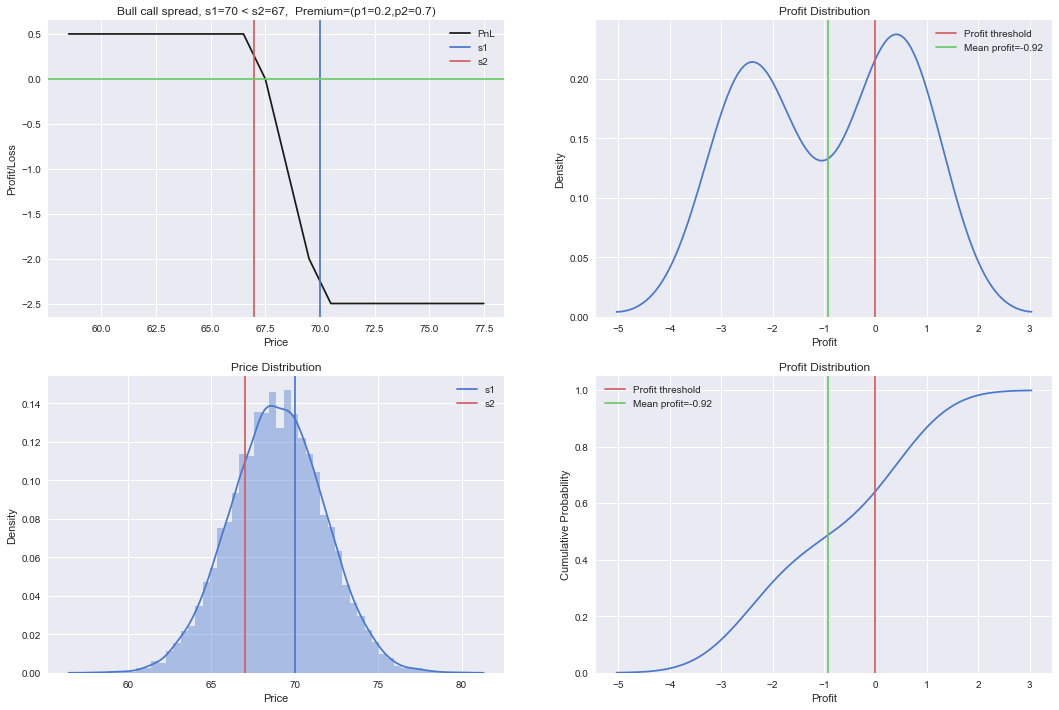

In [38]:
#Bull call - buy call with s1 and sell s2 where s1 < s2

#Settings
s1 = 70
s2 = 67
pr1 = 0.2
pr2 = 0.7

curr_price = 68.96
curr_vol = curr_price*(29.65/100)/np.sqrt(52)
N=10000
    
t1 = 68
t2 = np.arange((s1+s2)/2-10, (s1+s2)/2+10, 1.0)

norm_sim = np.random.normal(curr_price,curr_vol,N)
simulated_values = norm_sim #simdata.values
ls_call_pnl = long_short_call_pnl(s1,s2,pr1,pr2,t2)
avg_profit = np.round(np.mean(ls_call_pnl),2)


#Set plot area
sns.set(style="darkgrid")
f, axes = plt.subplots(2, 2, figsize=(18, 12), sharey=False, sharex=False)

#Plot Bull Call Strategy 
plotStrikeExtra(ax=axes[0,0]
                ,price=t2
                ,pnl_function=ls_call_pnl
                ,lbl='PnL'
                ,title=f'Bull call spread, s1={s1} < s2={s2},  Premium=(p1={pr1},p2={pr2})'
                ,xlab='Price'
                ,ylab='Profit/Loss'
                ,vstrike1=s1
                ,vstrike2=s2
               )

#Plot Density  
plotDensityBasic(ax=axes[1,0]
           ,data=simulated_values
           ,title=f'Price Distribution'
           ,xlab='Price'
           ,ylab='Density'
           ,vstrike1=s1
           ,vstrike2=s2    
            )

#Distribution and profit analysis
plotDensityExtra(ax=axes[0,1]
           ,data=ls_call_pnl
           ,title=f'Profit Distribution'
           ,xlab='Profit'
           ,ylab='Density'
           ,cuml=False
           ,t1=0
           ,tlab1='Profit threshold'
           ,t2=avg_profit
           ,tlab2=f'Mean profit={avg_profit}')  
    

#Plot profit CDF 
plotDensityExtra(ax=axes[1,1]
           ,data=ls_call_pnl
           ,title=f'Profit Distribution'
           ,xlab='Profit'
           ,ylab='Cumulative Probability'
           ,cuml=True
           ,t1=0
           ,tlab1='Profit threshold'
           ,t2=avg_profit
           ,tlab2=f'Mean profit={avg_profit}')  


#### Bull put spread :  buy s1 < sell s2 puts 

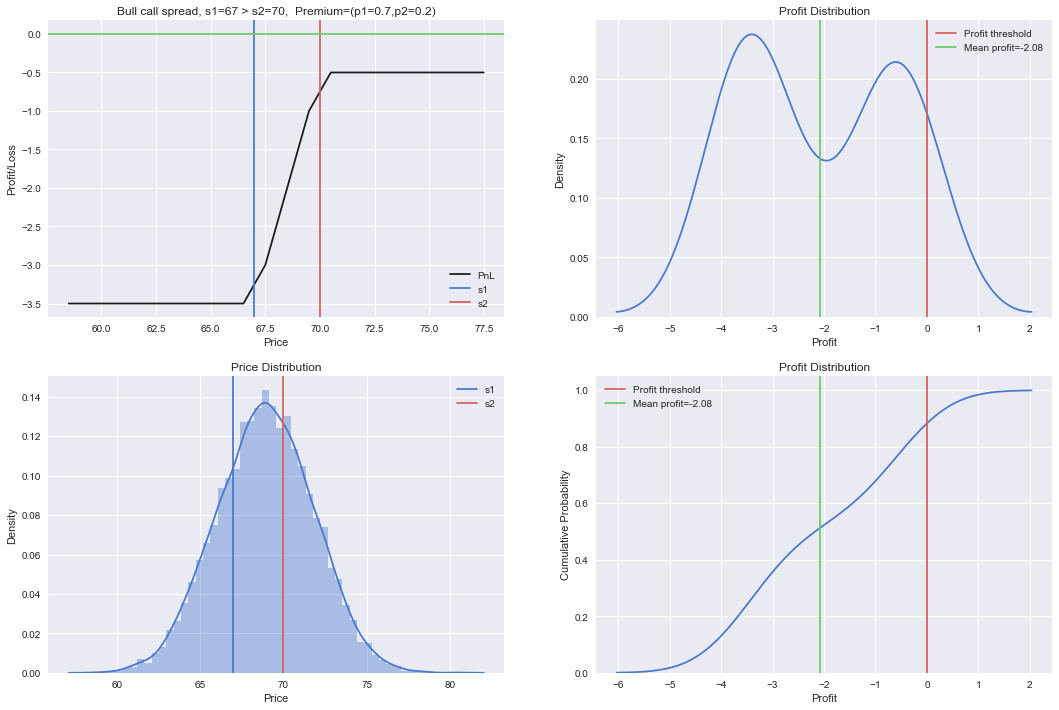

In [39]:
#Bull put - buy put with s1 and sell s2 where s1 < s2

#Settings
s1 = 67
s2 = 70
pr1 = 0.7
pr2 = 0.2

curr_price = 68.96
curr_vol = curr_price*(29.65/100)/np.sqrt(52)
N=10000
    
t1 = 68
t2 = np.arange((s1+s2)/2-10, (s1+s2)/2+10, 1.0)

norm_sim = np.random.normal(curr_price,curr_vol,N)
simulated_values = norm_sim #simdata.values
ls_put_pnl = long_short_put_pnl(s1,s2,pr1,pr2,t2)
avg_profit = np.round(np.mean(ls_put_pnl),2)


#Set plot area
sns.set(style="darkgrid")
f, axes = plt.subplots(2, 2, figsize=(18, 12), sharey=False, sharex=False)

#Plot Bull Call Strategy 
plotStrikeExtra(ax=axes[0,0]
                ,price=t2
                ,pnl_function=ls_put_pnl
                ,lbl='PnL'
                ,title=f'Bull call spread, s1={s1} > s2={s2},  Premium=(p1={pr1},p2={pr2})'
                ,xlab='Price'
                ,ylab='Profit/Loss'
                ,vstrike1=s1
                ,vstrike2=s2
               )

#Plot Density  
plotDensityBasic(ax=axes[1,0]
           ,data=simulated_values
           ,title=f'Price Distribution'
           ,xlab='Price'
           ,ylab='Density'
           ,vstrike1=s1
           ,vstrike2=s2    
            )

#Distribution and profit analysis
plotDensityExtra(ax=axes[0,1]
           ,data=ls_put_pnl
           ,title=f'Profit Distribution'
           ,xlab='Profit'
           ,ylab='Density'
           ,cuml=False
           ,t1=0
           ,tlab1='Profit threshold'
           ,t2=avg_profit
           ,tlab2=f'Mean profit={avg_profit}')  
    

#Plot profit CDF 
plotDensityExtra(ax=axes[1,1]
           ,data=ls_put_pnl
           ,title=f'Profit Distribution'
           ,xlab='Profit'
           ,ylab='Cumulative Probability'
           ,cuml=True
           ,t1=0
           ,tlab1='Profit threshold'
           ,t2=avg_profit
           ,tlab2=f'Mean profit={avg_profit}')  


### Bear spread

> A bear call spread is constructed by buying a call option of a certain strike price K and selling another call option of lower strike price.

> A bear put spread is constructed by buying higher striking in-the-money put options and selling the same number of lower striking out-of-the-money put options.

In [ ]:
#Bear call - buy call with s1 and sell s2 where s1 > s2
def bear_call_pnl(s1,s2,p1,p2,price):
    sp = np.add(call_profit_loss(s1,price,p1),short_call_pnl(s2,price,p2))
    return sp

#Bear put - buy put with s1 and sell s2 where s1 > s2

## Iron Condor

## Straddle

## Strangle

## Butterfly spread

In [30]:
#Check arbitrage
parity = 100 #shares per contract
courtage = 99 #SEK
strike = 70

#put
buy_put_nda70 = 2.10 #buy put = buy sell = buy option to sell -> I will SELL shares for strike if p < K
sell_put_nda70 = 1.30 #sell put = sell sell = sell option to sell -> I will BUY shares for strike if p < K

#call
buy_call_nda70 = 0.80 #buy call = buy buy = buy option to buy -> I will BUY shares for strike if p > K
sell_call_nda70 = 0.20 #sell call = sell buy = sell option to biy -> I will SELL shares for strike if p > K

#amounts
n_options = 10

#profit
n_options*parity*(sell_put_nda70 + sell_call_nda70) - 2*courtage
#above 75 / strike -> I need to SELL for 75
#below 65 / strike -> I need to BUY for 65
#-> amend strategy with buying call and put below/above 70/strike

1302.0

In [20]:
n_options*parity*strike

217500.0

In [ ]:
parity*n_options*()

In [28]:
(sell_call_nda70-buy_put_nda70 )

-1.9000000000000001